In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
sys.path.append('../../src')

from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy
from m3_learning.RHEED.Fitter1D import Model, Multiscale1DFitter


def collect_data(ys_nor_all, mean_length=2000, viz=False):

    ys_all_same_length = []
    for y in ys_nor_all:
        ys_all_same_length.append(np.interp(np.linspace(0, 1, mean_length), np.linspace(0, 1, len(y)), y))

    ys_all_same_length = np.array(ys_all_same_length)
    ys = torch.tensor(ys_all_same_length).float().unsqueeze(1)

    x = np.linspace(0, 1, mean_length)
    x = torch.tensor(x).float().unsqueeze(0)

    xs = x.repeat(ys.shape[0], 1, 1).squeeze().detach().numpy()
    if viz:
        print(xs.shape, ys.shape)
        Viz.plot_fit_details(xs, ys.squeeze().detach().numpy(), ys.squeeze().detach().numpy(), None, mod=5, labels=None, figsize=(12, 1.5*len(xs)//4+1), style='presentation')
    return xs, ys

def viz_fit(model, batch, device):
    inputs = batch[0].to(device).double()
    model = model.to(device).double()
    outputs, unscaled_param = model(inputs)
    labels = []
    for param in unscaled_param:
        labels.append(f'I/I0 = {param[0]:.2f} * 1-exp(-x/{param[1]:.2e})')

    xs = x.repeat(outputs.shape[0], 1, 1).squeeze().detach().cpu().numpy()
    ys = inputs.squeeze().detach().cpu().numpy()
    ys_fit = outputs.squeeze().detach().cpu().numpy()
    # print(xs.shape, ys.shape, ys_fit.shape)
    Viz.plot_fit_details(xs, ys, ys_fit, None, mod=5, labels=labels, figsize=(12, 1.5*len(xs)//4+1), style='presentation')
    

In [23]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    # [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info[3]
    ys_nor_all = info[3]
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)


para_path = './Datasets/J14_PM11_12_14_17_gaussian_fit_parameters.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 1000

ranges_list = [(40, 300), (52, 250), (8, 300), (0, 300)]
temp_list = ['temp350', 'temp400', 'temp450', 'temp800']
tau_list = []

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    ys_nor_all = info[3]
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)


x = torch.tensor(np.linspace(0, 1, 2000))
ys = torch.cat(ys_list, 0)
ys.shape

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.array(ys

temp350


KeyError: 'viz_tau'

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
sys.path.append('../../../../helper_functions')
from standard_train_functions import train_epochs

def exponential_fit_func(params, x, device=torch.device('cpu')):
    x = x.repeat(params.shape[0], 1, 1)
    x = torch.permute(x, (1,2,0))
    b = params[:, 0].type(torch.float64)
    tau = params[:, 1].type(torch.float64)
    tau = torch.relu(tau)

    params = params.to(device)
    x = torch.tensor(x).to(device)
    y = b * (1 - torch.exp(-x / tau))
    y = torch.permute(y, (2,0,1))
    return y
params = torch.randn([113, 2])
out = exponential_fit_func(params, x)
out.shape

C:\Users\yig319\AppData\Local\Temp\ipykernel_4864\1226962991.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


torch.Size([113, 1, 2000])

In [ ]:
dataset = TensorDataset(ys)
train_ds, valid_ds = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_dl = DataLoader(train_ds, shuffle=True, num_workers=3, batch_size=16) 
valid_dl = DataLoader(valid_ds, shuffle=True, num_workers=3, batch_size=16) 
y_batch = next(iter(train_dl))
y_batch[0].shape

torch.Size([16, 1, 2000])

In [56]:
model = Multiscale1DFitter(exponential_fit_func, x_data=x, input_channels=1, num_params=2, device=torch.device('cpu'))
model.training = True
out, unscaled_param = model(ys[:100])
# x.shape, y.shape, out.shape, unscaled_param.shape

C:\Users\yig319\AppData\Local\Temp\ipykernel_4864\1226962991.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


In [64]:
def mse_loss(input, target):
    return torch.sum((input - target) ** 2)

def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

class weighed_mse_loss(torch.nn.Module):
    def __init__(self, weight):
        super(weighed_mse_loss, self).__init__()
        # self.weight = weight
        # normalize weight
        self.weight = weight * 1.0 / torch.mean(weight)

    def forward(self, input, target):
        return torch.mean(self.weight * (input - target) ** 2)

In [61]:
mse_weights = torch.ones(ys.shape[-1])
mse_weights[:int(ys.shape[-1]*0.2)] *= 2
loss_func = weighed_mse_loss(mse_weights)

In [63]:
loss_func.weight.mean()

tensor(1.)

In [65]:
epochs=100
lr=1e-3
# loss_func = torch.nn.MSELoss()
mse_weights = torch.ones(ys.shape[-1])
mse_weights[:int(ys.shape[-1]*0.2)] *= 2
loss_func = weighed_mse_loss(mse_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
device = torch.device('cpu')
def predict_func(model, batch, device):
    # print(batch)
    inputs = batch[0].to(device).double()
    # print(inputs.dtype)
    model = model.to(device).double()
    # print(model.device, inputs.device)
    outputs, unscaled_param = model(inputs)
    # print(unscaled_param[:5])
    return outputs, inputs, inputs
history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, test_dl=None, predict_func=predict_func, epochs=epochs, 
             scheduler=scheduler, accuracy=False)

Epoch: 1/100


  0%|          | 0/26 [00:00<?, ?it/s]C:\Users\yig319\AppData\Local\Temp\ipykernel_4864\1226962991.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
100%|██████████| 26/26 [00:02<00:00, 11.67it/s]


Training Loss: 1.7649


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.4319
Epoch: 2/100


100%|██████████| 26/26 [00:02<00:00, 12.00it/s]


Training Loss: 1.7617


100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Validation Loss: 7.4274
Epoch: 3/100


100%|██████████| 26/26 [00:02<00:00, 12.02it/s]


Training Loss: 1.7586


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Validation Loss: 7.4218
Epoch: 4/100


100%|██████████| 26/26 [00:02<00:00, 11.65it/s]


Training Loss: 1.7548


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Validation Loss: 7.4136
Epoch: 5/100


100%|██████████| 26/26 [00:02<00:00, 11.88it/s]


Training Loss: 1.7486


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.4028
Epoch: 6/100


100%|██████████| 26/26 [00:02<00:00, 11.70it/s]


Training Loss: 1.7395


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.3981
Epoch: 7/100


100%|██████████| 26/26 [00:02<00:00, 11.91it/s]


Training Loss: 1.7290


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.4016
Epoch: 8/100


100%|██████████| 26/26 [00:02<00:00, 11.89it/s]


Training Loss: 1.7234


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.4061
Epoch: 9/100


100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


Training Loss: 1.7181


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.4135
Epoch: 10/100


100%|██████████| 26/26 [00:02<00:00, 11.70it/s]


Training Loss: 1.7115


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.4119
Epoch: 11/100


100%|██████████| 26/26 [00:02<00:00, 11.72it/s]


Training Loss: 1.7103


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Validation Loss: 7.4196
Epoch: 12/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.7109


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.4188
Epoch: 13/100


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


Training Loss: 1.7067


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.4196
Epoch: 14/100


100%|██████████| 26/26 [00:02<00:00, 11.73it/s]


Training Loss: 1.7015


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.3944
Epoch: 15/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.7124


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.3775
Epoch: 16/100


100%|██████████| 26/26 [00:02<00:00, 11.88it/s]


Training Loss: 1.6967


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.3866
Epoch: 17/100


100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


Training Loss: 1.6947


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.3814
Epoch: 18/100


100%|██████████| 26/26 [00:02<00:00, 12.00it/s]


Training Loss: 1.6938


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.3818
Epoch: 19/100


100%|██████████| 26/26 [00:02<00:00, 11.77it/s]


Training Loss: 1.7007


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.5392
Epoch: 20/100


100%|██████████| 26/26 [00:02<00:00, 11.93it/s]


Training Loss: 1.7018


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.2916
Epoch: 21/100


100%|██████████| 26/26 [00:02<00:00, 11.80it/s]


Training Loss: 1.6488


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.2660
Epoch: 22/100


100%|██████████| 26/26 [00:02<00:00, 11.89it/s]


Training Loss: 1.6602


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.2305
Epoch: 23/100


100%|██████████| 26/26 [00:02<00:00, 11.75it/s]


Training Loss: 1.6446


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Validation Loss: 7.2197
Epoch: 24/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6366


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.2077
Epoch: 25/100


100%|██████████| 26/26 [00:02<00:00, 11.75it/s]


Training Loss: 1.6358


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 7.2090
Epoch: 26/100


100%|██████████| 26/26 [00:02<00:00, 11.70it/s]


Training Loss: 1.6353


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1997
Epoch: 27/100


100%|██████████| 26/26 [00:02<00:00, 11.71it/s]


Training Loss: 1.6344


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Validation Loss: 7.1932
Epoch: 28/100


100%|██████████| 26/26 [00:02<00:00, 11.67it/s]


Training Loss: 1.6339


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1921
Epoch: 29/100


100%|██████████| 26/26 [00:02<00:00, 11.78it/s]


Training Loss: 1.6353


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.1900
Epoch: 30/100


100%|██████████| 26/26 [00:02<00:00, 11.61it/s]


Training Loss: 1.6338


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1901
Epoch: 31/100


100%|██████████| 26/26 [00:02<00:00, 11.59it/s]


Training Loss: 1.6340


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.1981
Epoch: 32/100


100%|██████████| 26/26 [00:02<00:00, 11.77it/s]


Training Loss: 1.6371


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1951
Epoch: 33/100


100%|██████████| 26/26 [00:02<00:00, 11.76it/s]


Training Loss: 1.6330


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.1942
Epoch: 34/100


100%|██████████| 26/26 [00:02<00:00, 11.71it/s]


Training Loss: 1.6331


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1867
Epoch: 35/100


100%|██████████| 26/26 [00:02<00:00, 11.83it/s]


Training Loss: 1.6335


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1924
Epoch: 36/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6330


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.1948
Epoch: 37/100


100%|██████████| 26/26 [00:02<00:00, 11.94it/s]


Training Loss: 1.6325


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.2206
Epoch: 38/100


100%|██████████| 26/26 [00:02<00:00, 11.72it/s]


Training Loss: 1.6361


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.1972
Epoch: 39/100


100%|██████████| 26/26 [00:02<00:00, 11.91it/s]


Training Loss: 1.6323


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1993
Epoch: 40/100


100%|██████████| 26/26 [00:02<00:00, 11.87it/s]


Training Loss: 1.6319


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.1977
Epoch: 41/100


100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


Training Loss: 1.6323


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.2033
Epoch: 42/100


100%|██████████| 26/26 [00:02<00:00, 11.91it/s]


Training Loss: 1.6328


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


Validation Loss: 7.1999
Epoch: 43/100


100%|██████████| 26/26 [00:02<00:00, 11.89it/s]


Training Loss: 1.6317


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1971
Epoch: 44/100


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


Training Loss: 1.6326


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.2136
Epoch: 45/100


100%|██████████| 26/26 [00:02<00:00, 11.76it/s]


Training Loss: 1.6332


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.2034
Epoch: 46/100


100%|██████████| 26/26 [00:02<00:00, 11.78it/s]


Training Loss: 1.6317


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


Validation Loss: 7.2006
Epoch: 47/100


100%|██████████| 26/26 [00:02<00:00, 11.68it/s]


Training Loss: 1.6352


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.2179
Epoch: 48/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.6410


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 7.2131
Epoch: 49/100


100%|██████████| 26/26 [00:02<00:00, 11.87it/s]


Training Loss: 1.6336


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1998
Epoch: 50/100


100%|██████████| 26/26 [00:02<00:00, 11.87it/s]


Training Loss: 1.6332


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.2001
Epoch: 51/100


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


Training Loss: 1.6326


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Validation Loss: 7.1960
Epoch: 52/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6325


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1930
Epoch: 53/100


100%|██████████| 26/26 [00:02<00:00, 11.93it/s]


Training Loss: 1.6333


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1951
Epoch: 54/100


100%|██████████| 26/26 [00:02<00:00, 11.93it/s]


Training Loss: 1.6323


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.1896
Epoch: 55/100


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


Training Loss: 1.6318


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Validation Loss: 7.1904
Epoch: 56/100


100%|██████████| 26/26 [00:02<00:00, 11.73it/s]


Training Loss: 1.6320


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.1888
Epoch: 57/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6316


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1887
Epoch: 58/100


100%|██████████| 26/26 [00:02<00:00, 11.89it/s]


Training Loss: 1.6315


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1880
Epoch: 59/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6314


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.1872
Epoch: 60/100


100%|██████████| 26/26 [00:02<00:00, 11.80it/s]


Training Loss: 1.6313


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1880
Epoch: 61/100


100%|██████████| 26/26 [00:02<00:00, 11.71it/s]


Training Loss: 1.6313


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Validation Loss: 7.1869
Epoch: 62/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6311


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1873
Epoch: 63/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6318


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1867
Epoch: 64/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.6313


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Validation Loss: 7.1883
Epoch: 65/100


100%|██████████| 26/26 [00:02<00:00, 11.83it/s]


Training Loss: 1.6313


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1873
Epoch: 66/100


100%|██████████| 26/26 [00:02<00:00, 11.96it/s]


Training Loss: 1.6309


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Validation Loss: 7.1865
Epoch: 67/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6311


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Validation Loss: 7.1883
Epoch: 68/100


100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


Training Loss: 1.6309


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1864
Epoch: 69/100


100%|██████████| 26/26 [00:02<00:00, 11.87it/s]


Training Loss: 1.6308


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1859
Epoch: 70/100


100%|██████████| 26/26 [00:02<00:00, 11.73it/s]


Training Loss: 1.6308


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.1863
Epoch: 71/100


100%|██████████| 26/26 [00:02<00:00, 11.74it/s]


Training Loss: 1.6307


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.1849
Epoch: 72/100


100%|██████████| 26/26 [00:02<00:00, 11.90it/s]


Training Loss: 1.6311


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.1859
Epoch: 73/100


100%|██████████| 26/26 [00:02<00:00, 11.82it/s]


Training Loss: 1.6309


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Validation Loss: 7.1855
Epoch: 74/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6306


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Validation Loss: 7.1858
Epoch: 75/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6306


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1847
Epoch: 76/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.6305


100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


Validation Loss: 7.1849
Epoch: 77/100


100%|██████████| 26/26 [00:02<00:00, 11.86it/s]


Training Loss: 1.6306


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Validation Loss: 7.1849
Epoch: 78/100


100%|██████████| 26/26 [00:02<00:00, 11.68it/s]


Training Loss: 1.6305


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Validation Loss: 7.1847
Epoch: 79/100


100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


Training Loss: 1.6305


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Validation Loss: 7.1847
Epoch: 80/100


100%|██████████| 26/26 [00:02<00:00, 11.90it/s]


Training Loss: 1.6304


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Validation Loss: 7.1847
Epoch: 81/100


100%|██████████| 26/26 [00:02<00:00, 11.95it/s]


Training Loss: 1.6304


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Validation Loss: 7.1841
Epoch: 82/100


100%|██████████| 26/26 [00:02<00:00, 11.81it/s]


Training Loss: 1.6305


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 7.1841
Epoch: 83/100


100%|██████████| 26/26 [00:02<00:00, 11.70it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Validation Loss: 7.1842
Epoch: 84/100


100%|██████████| 26/26 [00:02<00:00, 11.71it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Validation Loss: 7.1844
Epoch: 85/100


100%|██████████| 26/26 [00:02<00:00, 11.84it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 7.1844
Epoch: 86/100


100%|██████████| 26/26 [00:02<00:00, 11.95it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


Validation Loss: 7.1841
Epoch: 87/100


100%|██████████| 26/26 [00:02<00:00, 11.78it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 7.1844
Epoch: 88/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Validation Loss: 7.1844
Epoch: 89/100


100%|██████████| 26/26 [00:02<00:00, 11.79it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Validation Loss: 7.1845
Epoch: 90/100


100%|██████████| 26/26 [00:02<00:00, 11.80it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 7.1845
Epoch: 91/100


100%|██████████| 26/26 [00:02<00:00, 11.76it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Validation Loss: 7.1845
Epoch: 92/100


100%|██████████| 26/26 [00:02<00:00, 11.75it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Validation Loss: 7.1845
Epoch: 93/100


100%|██████████| 26/26 [00:02<00:00, 11.78it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Validation Loss: 7.1846
Epoch: 94/100


100%|██████████| 26/26 [00:02<00:00, 11.80it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 7.1846
Epoch: 95/100


100%|██████████| 26/26 [00:02<00:00, 12.04it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Validation Loss: 7.1846
Epoch: 96/100


100%|██████████| 26/26 [00:02<00:00, 11.62it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Validation Loss: 7.1846
Epoch: 97/100


100%|██████████| 26/26 [00:02<00:00, 11.64it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


Validation Loss: 7.1846
Epoch: 98/100


100%|██████████| 26/26 [00:02<00:00, 10.77it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Validation Loss: 7.1846
Epoch: 99/100


100%|██████████| 26/26 [00:02<00:00, 11.62it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 7.1846
Epoch: 100/100


100%|██████████| 26/26 [00:02<00:00, 11.73it/s]


Training Loss: 1.6303


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

Validation Loss: 7.1846


C:\Users\yig319\AppData\Local\Temp\ipykernel_4864\1226962991.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


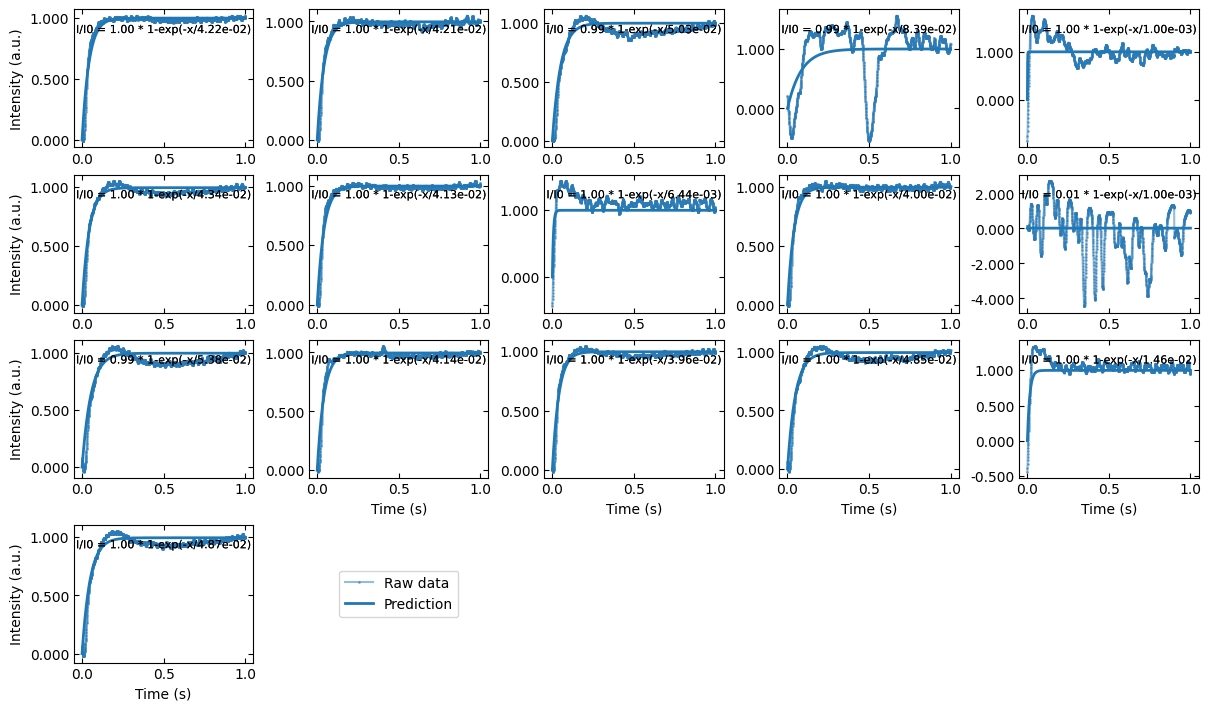

In [66]:
batch = next(iter(train_dl))
viz_fit(model, batch, device)

C:\Users\yig319\AppData\Local\Temp\ipykernel_4864\1226962991.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)


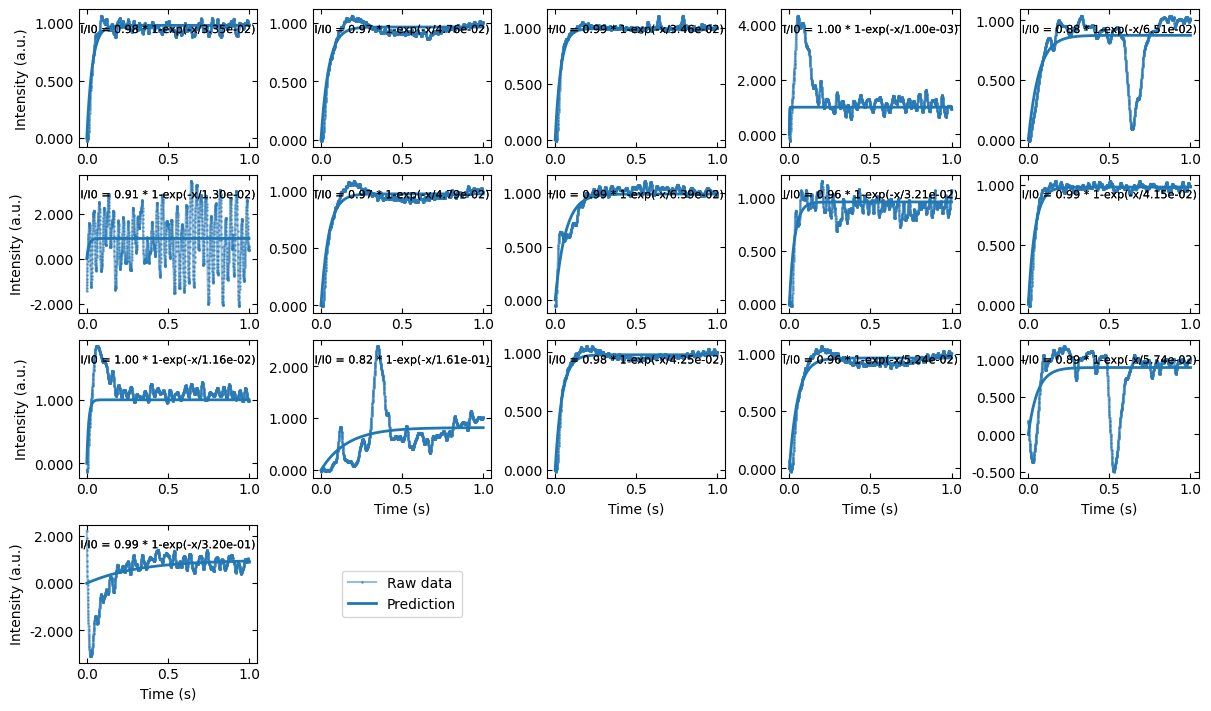

In [22]:
batch = next(iter(train_dl))
viz_fit(model, batch, device)